# Data-Centric AI Competition 2021
## Full Notebook
### Best Submission (from Kenneth Leung)

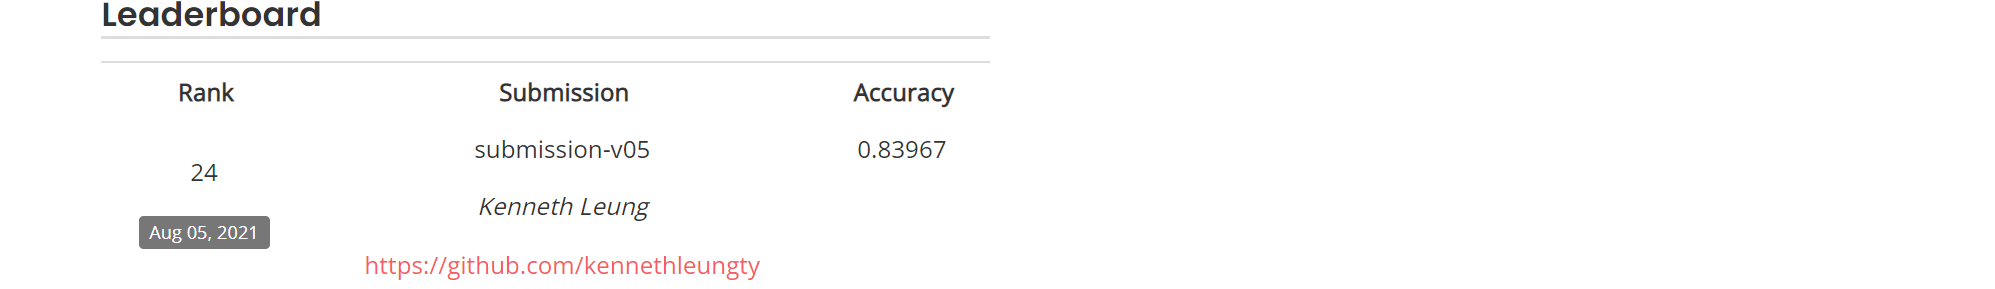

### Contents
1. [Initial Setup](#initial-setup)
2. [Data Exploration](#initial-setup)
___

## 1. Initial Setup

#### Import dependencies

In [ ]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
from torchvision import datasets, models            # vision datasets,architectures & transforms
import torchvision.transforms as T                  # composable transforms
torch.manual_seed(42)
import imgaug as ia
from imgaug import augmenters as iaa
import os
from pathlib import Path
from glob import glob
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps
from scipy.ndimage.interpolation import shift
from skimage.filters import threshold_otsu

# Define locations of cleaned data to perform augmentation on
CLEAN_DATA_FOLDER = 'data/1_clean'
TRAIN_DATA = f'{CLEAN_DATA_FOLDER}/train'
VALID_DATA = f'{CLEAN_DATA_FOLDER}/val'

# Set seed
ia.seed(1)

#### View train.py file provided
This is the script that will be run to train the default model on the data we will eventually enhance

In [2]:
# View train.py file provided
!pygmentize scripts/train.py

# You can try fixing incorrect labels, adding data for side case tuning, apply
# data augmentation techniques, or use any other method to improve the data.
# You may also find it helpful to take a look at the training script to get a
# better sense of the preprocessing and model (these are held fixed). The script
# will resize all images to (32, 32) and run them through a cut off ResNet50

import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys

directory = "YOUR_DIRECTORY_NAME_HERE"
user_data = directory + "/train"
valid_data = directory + "/val"
test_data = directory + "/test" # this can be the label book, or any other test set you create

### DO NOT MODIFY BELOW THIS LINE, THIS IS THE FIXED MODEL ###
batch_size = 8
tf.random.set_seed(123)


if __name__ == "__main__":
    train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/train',
        labels="inferred",
        label_mode="categorical",
        class_names=["i"

#### Define paths
The raw dataset comes with two folders (train and val), with each of them having subfolders containing respective images of the Roman numerals:  

    raw/  
    │  
    └───train/ 
    │        i/
    │        ii/
    │        iii/
    │        iv/
    │        v/
    |        vi/
    |        vii/
    |        viii/
    |        ix/
    |        x/    
    └───val/ 
             i/
             ii/
             iii/
             iv/
              v/
             vi/
             vii/
             viii/
             ix/
             x/  

        


In [3]:
RAW_DATA_FOLDER = 'data/0_raw'
TRAIN_DATA = f'{RAW_DATA_FOLDER}/train'
VALID_DATA = f'{RAW_DATA_FOLDER}/val'
print(f'Train data folder: {os.listdir(TRAIN_DATA)}')
print(f'Validation data folder: {os.listdir(VALID_DATA)}')

Train data folder: ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
Validation data folder: ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


In [5]:
# Count number of images in raw dataset
train_img_count = len([os.path.join(dirpath, filename) for dirpath, _, filenames in os.walk(TRAIN_DATA) for filename in filenames])
valid_img_count = len([os.path.join(dirpath, filename) for dirpath, _, filenames in os.walk(VALID_DATA) for filename in filenames])
print(f'Number of train images: {train_img_count}')
print(f'Number of validation images: {valid_img_count}')
print(f'Total number of images: {train_img_count + valid_img_count}')

Number of train images: 2068
Number of validation images: 813
Total number of images: 2881


In [4]:
images = []
labels = []

for folder in os.listdir(TRAIN_DATA):
      for image in os.listdir(TRAIN_DATA + '/' + folder):
        images.append(os.path.join(TRAIN_DATA, folder, image))
        labels.append(folder)

# plt.figure(1, figsize=(15, 9))
# plt.axis('off')
# n = 0

# for i in range(36):
#     n += 1
#     random_index = random.choice(range(len(images)))
#     random_label = labels[random_index]
#     random_img = images[random_index]
#     img = cv2.imread(random_img, cv2.IMREAD_GRAYSCALE)
#     plt.subplot(6, 6, n)
#     plt.axis('off')
#     plt.imshow(img, cmap=plt.get_cmap('gray'))
#     plt.title(random_label)

# plt.show()

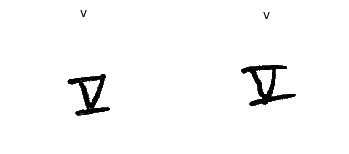

In [7]:
# Show images side by side
random_index = random.choice(range(len(images)))
random_index_2 = random_index + 1

img_1 = cv2.imread(images[random_index], cv2.IMREAD_GRAYSCALE)
img_2 = cv2.imread(images[random_index_2], cv2.IMREAD_GRAYSCALE)

# display images
fig, ax = plt.subplots(1,2)
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title(labels[random_index])
ax[1].set_title(labels[random_index_2])

ax[0].imshow(img_1, cmap=plt.get_cmap('gray'));
ax[1].imshow(img_2, cmap=plt.get_cmap('gray'));

In [17]:
# Get dimensions and file extensions of images in TRAIN data
dimensions = []
file_ext = []

for folder in os.listdir(TRAIN_DATA):
      for image in os.listdir(TRAIN_DATA + '/' + folder):
        img_path = os.path.join(TRAIN_DATA, folder, image)
        img_ext = image.split('.')[-1]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        try:
            dimensions.append(img.shape)
            file_ext.append(img_ext)
        except:
            print(f'NoneType image: {img_path}')

In [25]:
Counter(dimensions).most_common()

[((253, 259), 9),
 ((253, 264), 9),
 ((232, 232), 8),
 ((253, 286), 8),
 ((264, 280), 8),
 ((253, 253), 7),
 ((231, 264), 7),
 ((253, 247), 7),
 ((253, 248), 7),
 ((225, 264), 6),
 ((242, 247), 6),
 ((275, 264), 6),
 ((253, 242), 6),
 ((270, 264), 6),
 ((255, 267), 6),
 ((286, 275), 6),
 ((253, 280), 6),
 ((231, 258), 6),
 ((242, 242), 5),
 ((270, 258), 5),
 ((275, 259), 5),
 ((237, 234), 5),
 ((270, 259), 5),
 ((248, 242), 5),
 ((276, 222), 4),
 ((232, 248), 4),
 ((270, 247), 4),
 ((275, 319), 4),
 ((225, 279), 4),
 ((242, 264), 4),
 ((280, 247), 4),
 ((286, 253), 4),
 ((270, 286), 4),
 ((255, 264), 4),
 ((275, 286), 4),
 ((253, 314), 4),
 ((253, 231), 4),
 ((253, 258), 4),
 ((264, 286), 4),
 ((261, 267), 4),
 ((259, 198), 4),
 ((330, 429), 4),
 ((209, 242), 4),
 ((286, 280), 4),
 ((201, 252), 3),
 ((240, 232), 3),
 ((208, 240), 3),
 ((201, 222), 3),
 ((216, 232), 3),
 ((240, 240), 3),
 ((237, 237), 3),
 ((269, 220), 3),
 ((225, 252), 3),
 ((232, 240), 3),
 ((264, 237), 3),
 ((208, 23

Different files have different dimensions

In [23]:
# Get file extension
Counter(file_ext)

Counter({'png': 2067})

All files are .png format